### <strong><font color=cornflowerblue>第二次作品：SVD 於影像矩陣中的應用</font></strong>
學號：411078064

姓名：謝意盛
<hr>

### <strong>作品目標</strong>：

本實驗將圍繞 Singular Value Decomposition（簡稱 SVD）進行探討。
首先，已知 Principal Component Analysis（簡稱 PCA）與 SVD 在背後的數學原理上有密切的關聯，故實驗的第一個重點將分別從 PCA 與 SVD 的角度來進行影像壓縮，比較兩者壓縮出的影像是否存在差異，以此驗證其背後的理論。
此外，SVD 在影像壓縮上被廣泛應用，通過 SVD 進行矩陣分解，再通過 Rank q approximation，可將影像的大小壓縮，節省儲存空間，方便影像的轉移與儲存，但可知當 q 值越小，影像的清晰度將越模糊，因此實驗的第二個重點將探討通過將圖片切割成一張張小圖，再通過 SVD 進行壓縮，觀察將圖片切割得越小，或越大，是否可以改善當 q 值很小時的清晰度。
最後，本實驗通過使用人臉特徵 $U_q$ 來對人臉，以及其他非人臉影像進行加密，後再解密，觀察解密後的影像效果，相較於人臉影像，是否其他非人臉影像的效果較差。

<hr>

#### <strong>參考資料</font>：

1. [汪群超 Chun-Chao Wang 老師講義](https://ntpuccw.blog/python-in-learning/sml%e6%b7%ba%e5%ba%a6%e6%a9%9f%e5%99%a8%e5%ad%b8%e7%bf%92%ef%bc%9apca-%e3%80%81svd-%e5%8f%8a%e5%85%b6%e5%9c%a8%e5%bd%b1%e5%83%8f%e8%99%95%e7%90%86%e7%9a%84%e6%87%89%e7%94%a8/)

<hr>

#### <strong>載入套件</strong>：

In [2]:
import pickle
import os
import pandas as pd
import numpy as np
from numpy.linalg import svd
# from scipy.linalg import svd
import scipy.io
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage import io
from skimage.util import view_as_blocks  # get patches
from skimage.transform import resize  # resize image
from sklearn.decomposition import PCA, TruncatedSVD

# 第一題資料
from sklearn.datasets import fetch_openml

# MyLib
import MyLib  # 自己寫的函式庫
from importlib import reload
reload(MyLib) # 重新載入MyLib，這樣才會更新
from MyLib import show_montage
from MyLib import montage


<hr>
<hr>

### **<font color=cornflowerblue>第 1 題：</font>**  

本題以數字圖像為例，分別從 PCA 與 SVD 的角度來進行影像壓縮，觀察與比較兩者之間的差異。

**資料來源：** `from sklearn.datasets import fetch_openml`。

**公式說明：** 

- 一個 $m \times n$ 的資料矩陣 $X$ 可以進行奇異值分解（SVD），分解為三個矩陣的乘積：
    $$ X = \sum_{k=1}^{r}\sigma_{k}\mathbf{u}_{k}\mathbf{v}_{k}^{T} = U \Sigma V^{T} $$
    其中：
    - $U$：為 $m \times r$ 的正交矩陣，包含左奇異向量（代表資料的投影方向）。
    - $\Sigma$：為 $r \times r$ 的對角矩陣，對角線上的值為奇異值（依大小排列）。
    - $V^{T}$：為 $r \times n$ 的正交矩陣，包含右奇異向量（即主成分方向）。

- 此外，也可寫成：
    $$ X = \sum_{k=1}^{r}\sigma_{k}\mathbf{u}_{k}\mathbf{v}_{k}^{T} = U \Sigma V^{T} = UU^{T}X = UZ $$
    其中：
    - $Z = \Sigma V^{T} = U^{T}X$，即為資料在主成分方向上的座標。

- 若只保留前 $q$ 項最大的奇異值及對應向量，可得 **Rank q approximation**，即為影像壓縮的核心概念，可表達成：
    $$ X_{q} = \sum_{k=1}^{q}\sigma_{k}\mathbf{u}_{k}\mathbf{v}_{k}^{T} = U_{q} \Sigma_{q} V^{T}_{q} = U_{q}U^{T}_{q}X_{q} = U_{q}Z_{q} $$

#### (1) 匯入資料，觀察資料的基本屬性。

In [3]:
# 匯入資料
path = r'C:\Users\Sheng\Documents\NTPU_Bachelor\Year_4\Y4_Sem_2\ShallowML\ClassData'
os.makedirs(path, exist_ok=True)
data_file = os.path.join(path, 'mnist_digits_784.pkl')

# Check if data file exists, else download data from internet
if os.path.isfile(data_file):
    # Load data from file
    with open(data_file, 'rb') as f:
        data = pickle.load(f)
else:
    data = fetch_openml('mnist_784', version=1, parser='auto')
    # Save data to file
    with open(data_file, 'wb') as f:
        pickle.dump(data, f)

# 資料集說明
# print('【資料說明】:\n', data.DESCR)
print('\n【資料集的 Keys】:', data.keys())
print('【資料的 Shape】:', data.data.shape)
print('【Target 的 Shape】:', data.target.shape)
print('【Target 的 Unique】:', np.unique(data.target))
print('【資料前 5 筆】:\n', data.data[:5])

# Extract data and labels
X, y = np.array(data.data).T, np.array(data.target).astype('int')


【資料集的 Keys】: dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])
【資料的 Shape】: (70000, 784)
【Target 的 Shape】: (70000,)
【Target 的 Unique】: ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']
【資料前 5 筆】:
    pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  pixel9  \
0       0       0       0       0       0       0       0       0       0   
1       0       0       0       0       0       0       0       0       0   
2       0       0       0       0       0       0       0       0       0   
3       0       0       0       0       0       0       0       0       0   
4       0       0       0       0       0       0       0       0       0   

   pixel10  ...  pixel775  pixel776  pixel777  pixel778  pixel779  pixel780  \
0        0  ...         0         0         0         0         0         0   
1        0  ...         0         0         0         0         0         0   
2        0  ...         0         0         0  

<hr>

#### (2) 使用 PCA 套件來進行影像壓縮（Rank q approximation），並觀察其壓縮效果。

套件：`from sklearn.decomposition import PCA`

##### 1) 本題挑選所有數字 7 的圖片進行實驗，下面顯示出前 50 張圖片。

【數字 7 圖片的 shape】: (784, 7293)
【數字 7 圖片的總數】: 7293


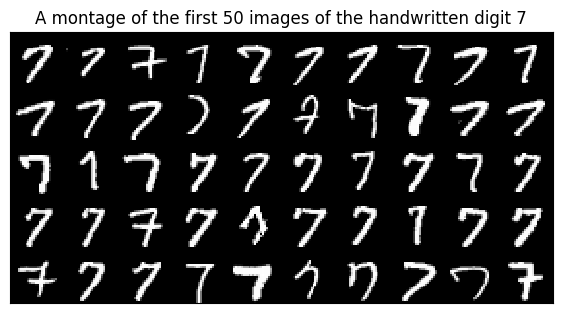

In [46]:
digit_to_show = 7
Digit = X[:, y==digit_to_show]
m, n = 5, 10
M = montage(Digit, m, n)
print('【數字 7 圖片的 shape】:', Digit.shape)
print('【數字 7 圖片的總數】:', Digit.shape[1])

plt.figure(figsize = (7, 4))
plt.imshow(M, cmap = 'gray', interpolation = 'nearest')
plt.xticks([])
plt.yticks([])
plt.title('A montage of the first 50 images of the handwritten digit 7')
plt.show()

##### 2) 對所有數字 7 的圖片進行 **Rank q approximation**，其中 q = 1，取得與原圖同樣大小與張數的近似圖片，並觀察前 20 張近似圖片的模樣。

**注意事項：**
1. q 值代表在將影像矩陣進行分解時，所保留的主成分數量。
1. PCA 套件會事先將資料置中（減去平均數），因此圖片進行壓縮後，要加回平均數（pca.mean_）才能呈現回真正壓縮後的模樣。

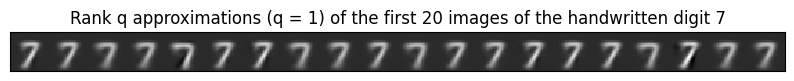

In [9]:
# 取出 digit 7 的資料
digit_to_show = 7
Digit = X[:, y==digit_to_show].T

# 定義 q 值
All_q = 30
q = 1

# 取出 All_q 個主成分
pca = PCA(n_components=All_q)
pca.fit(Digit) # Fit the model with X
# 原本 PCA 做法，取所有 q 個主成分
# Z = pca.transform(Digit)
# Z 是主成分的係數矩陣

# 只取 q 個主成分
Uq = pca.components_[:q, :].T
Zq = Uq.T @ Digit.T
Digitq = Uq @ Zq
# 以上計算在講義寫為：X_q = U_q @ U_q.T @ X，其中 U_q 為前 q 個主成分的 eigenvector

# PCA 會事前置中，所以 Digitq 要把 mean 加回去
Digitq = Digitq + pca.mean_[:, np.newaxis]

# 畫出圖片
plt.figure(figsize = (10, 3))
m, n = 1, 20
M = montage(Digitq, m, n)
plt.imshow(M, cmap = 'gray', interpolation = 'nearest')
plt.xticks([])
plt.yticks([])
plt.title('Rank q approximations (q = 1) of the first 20 images of the handwritten digit 7')
plt.show()

##### 3) 重複第 2 小題的步驟，但將 q 值設定為 1、3、5、 $\dots$ 、29，分別針對每個 q 值進行 **Rank q approximation**，並列印出各自的 20 張近似圖片，以觀察 q 值變化對影像品質的影響。

<!-- 執行結果的圖片說明：第 1 行是原圖，第 2 行是 q 值為 1 的近似圖片，第 3 行則是 q 值為 3 的近似圖片，以此類推。 -->

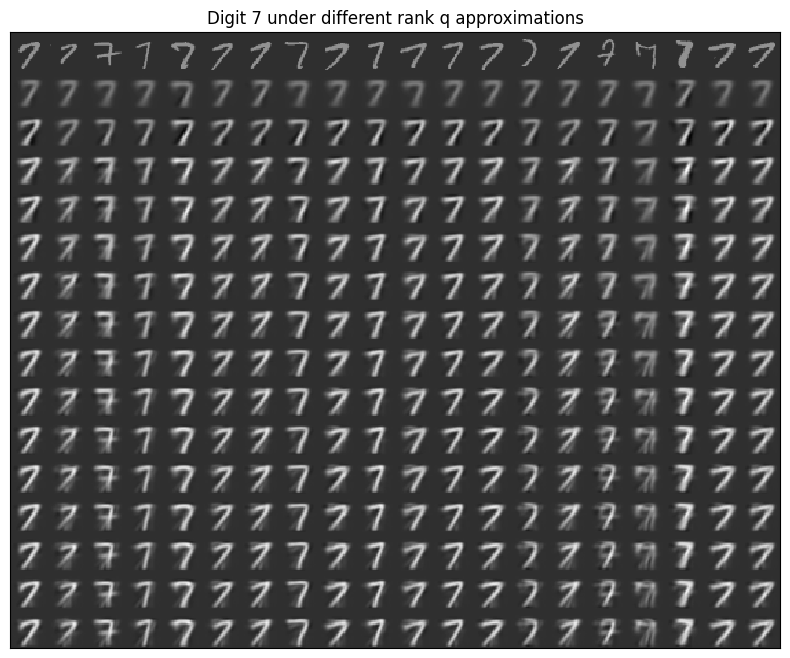

In [ ]:
# 取出 digit 7 的資料
digit_to_show = 7
Digit_orig = X[:, y==digit_to_show]
Digit_pca = Digit_orig.T

# 將 Digit_orig 前 20 筆資料存進 Digit_plot
Digit_plot = np.zeros((784, 20))
Digit_plot = Digit_orig[:, :20]

# 定義 q 值
All_q = np.arange(1, 31, 2)

# 取 All_q 個主成分
pca = PCA(n_components=max(All_q))
pca.fit(Digit_pca)

# 分別取每 q 個主成分
for q in All_q:
    Uq = pca.components_[:q, :].T
    Zq = Uq.T @ Digit_pca.T
    Digitq = Uq @ Zq
    # PCA 會事前做中心化，所以 Digitq 要把 mean 加回去
    Digitq = Digitq + pca.mean_[:, np.newaxis]

    # 將每個 Digitq 前 20 筆資料存進 Digit_plot 裡
    Digit_plot = np.hstack([Digit_plot, Digitq[:, :20]])

# 畫出圖片
plt.figure(figsize = (10, 8))
m, n = 16, 20  # A m x n montage (total mn images)
M = montage(Digit_plot, m, n)
plt.imshow(M, cmap = 'gray', interpolation = 'nearest')
plt.xticks([])
plt.yticks([])
plt.title('Digit 7 under different rank q approximations')
plt.show()

##### **<font color=lightseagreen>注意事項與討論：</font>**  

- 圖中展現了數字 7 的圖片在不同 q 值下經過 **Rank q approximation** 處理後的結果。每組結果皆呈現前 20 張數字 7 的圖片，其中第 1 行為原始圖片，第 2 行為 $q = 1$ 的近似圖片，第 3 行為 $q = 3$ 的結果，依此類推至 $q = 29$。

- 與第 1 行的原圖相比，可以觀察到當 $q$ 值極小（如 $q = 1$）時，20 張圖片的模樣幾乎相同，細節資訊大幅流失。隨著 $q$ 值增加，圖片逐漸展現出各自的細節與差異，逐步接近原始圖片的樣貌。

- 這顯示使用 PCA 套件確實能有效壓縮影像，並藉由調整 $q$ 值控制壓縮程度。當 $q$ 值較小時，近似圖片呈現出類似**標準寫法**的數字 7；隨著 $q$ 值增加，壓縮圖片逐漸融入不同寫法的特徵，最終逐步還原為原圖，呈現出每張圖片獨特的樣貌。

<hr>

#### (3) 分別使用 **NumPy** 與 **scikit-learn** 中的 SVD 套件進行影像壓縮（Rank q approximation），在壓縮效果與執行速度上的差異。接著，再將結果與 PCA 進行比較，探討 PCA 與 SVD 在影像壓縮上的差異。

**使用的套件：** 
1. `from numpy.linalg import svd`
1. `from sklearn.decomposition import TruncatedSVD`

##### 1) 使用 **NumPy** 提供的 SVD 套件對圖片進行 **Rank q approximation**，其中 $q$ 值設定為 1、3、5、 $\dots$ 、29。分別列印出每個 $q$ 值下的 20 張近似圖片，觀察不同 $q$ 值對影像的影響。

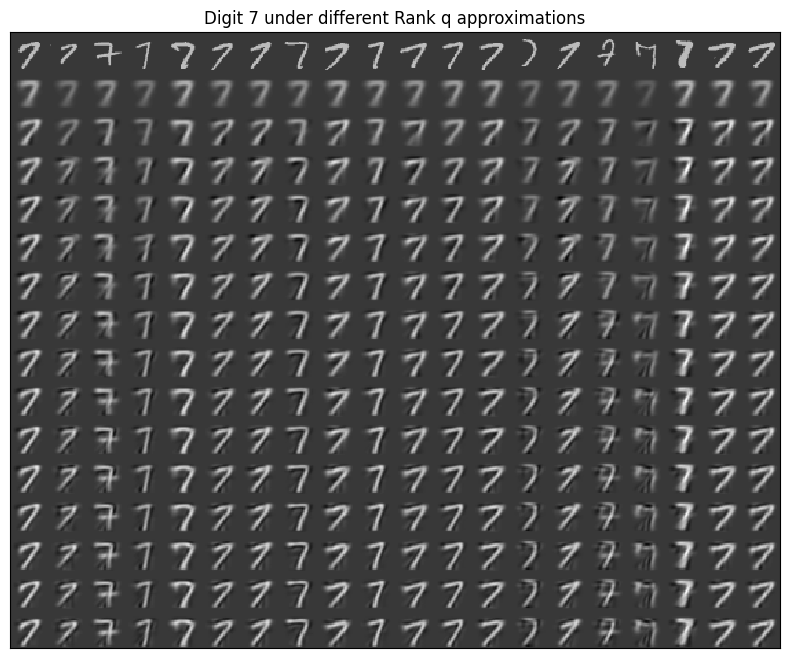

In [14]:
# 取出 digit 7 的資料
digit_to_show = 7
Digit = X[:, y==digit_to_show].T
# Digit = Digit - np.mean(Digit, axis = 0)  # 中心化資料

# 將 Digit 前 20 筆資料存進 Digit_plot
Digit_plot = np.zeros((20, 784))
Digit_plot = Digit[:20, :]

# 定義 q 值
All_q = np.arange(1, 31, 2)

# 進行 SVD 分解
# U = 左奇異向量矩陣, E = 奇異值矩陣, VT = 右奇異向量矩陣
U, E, VT = svd(Digit, full_matrices = False)

# # 保留前 q 個奇異值
# U_q = U[:, :q]        # 取 U 的前 q 列
# E_q = np.diag(E[:q])  # 取前 q 個奇異值，構造對角矩陣
# VT_q = VT[:q, :]      # 取 VT 的前 q 行
# Digitq = U_q @ E_q @ VT_q
# # 以上計算在講義寫為：X_q = U_q @ \Sigma_q @ V_q.T

# 分別取每 q 個主成分
for q in All_q:
    # 保留前 q 個奇異值
    U_q = U[:, :q]        # 取 U 的前 q 列
    E_q = np.diag(E[:q])  # 取前 q 個奇異值，構造對角矩陣
    VT_q = VT[:q, :]      # 取 VT 的前 q 行
    Digitq = U_q @ E_q @ VT_q

    # 將每個 Digitq 前 20 筆資料存進 Digit_plot 裡
    Digit_plot = np.vstack([Digit_plot, Digitq[:20, :]])

# 畫出圖片
plt.figure(figsize = (10, 8))
m, n = 16, 20  # A m x n montage (total mn images)
M = montage(Digit_plot.T, m, n)
plt.imshow(M, cmap = 'gray', interpolation = 'nearest')
plt.xticks([])
plt.yticks([])
plt.title('Digit 7 under different Rank q approximations')
plt.show()

##### **<font color=lightseagreen>注意事項與討論：</font>**  

- 圖中展示了數字 7 的圖片透過 **NumPy** 套件中的 SVD 函數，搭配不同的 $q$ 值進行 **Rank q approximation** 後的結果，與使用 PCA 套件所得到的壓縮效果相似。但是，若仔細觀察，可以發現兩者在相同 $q$ 值下生成的近似圖片仍存在些微差異，這可能與兩種方法在底層實作上採用不同的演算法有關。

- 整體呈現出的變化趨勢與 PCA 的壓縮結果相同。當 $q$ 值較小（如 $q = 1$)時，20 張圖片幾乎相同，細節資訊流失；而隨著 $q$ 值逐漸增加，圖片的細節與差異也逐步恢復，逐漸呈現出原始圖像的獨特特徵。

- 實驗結果證實，使用 SVD 同樣可以有效進行影像壓縮，其壓縮效果與 PCA 相當。因此，在實務應用中，兩者皆可用於影像降維與壓縮，主要取決於使用者對套件介面、效率與實作彈性的需求選擇。

##### 2) 使用 **scikit-learn** 套件中的 SVD 函數（`TruncatedSVD`）對圖片進行 **Rank q approximation**，其中 q 值設定為 1、3、5、 $\dots$ 、29，分別列印出每個 $q$ 值下的 20 張近似圖片，觀察不同 $q$ 值對影像的影響。

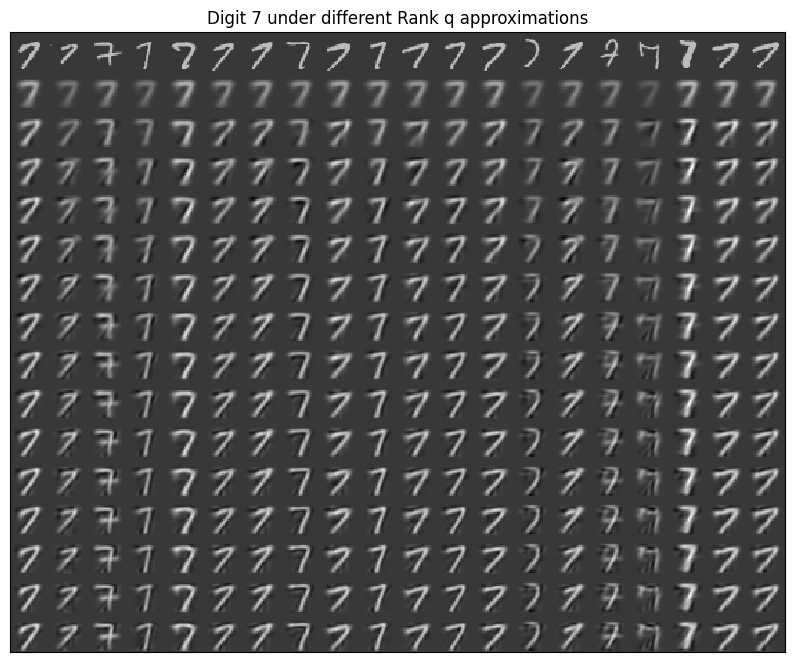

In [ ]:
# 取出 digit 7 的資料
digit_to_show = 7
Digit = X[:, y==digit_to_show]

# 將 Digit 前 20 筆資料存進 Digit_plot
Digit_plot = np.zeros((784, 20))
Digit_plot = Digit[:, :20]

# 定義 q 值
All_q = np.arange(1, 31, 2)

# 進行 SVD 分解
sksvd = TruncatedSVD(n_components=max(All_q), random_state = 0)    # 保留前 q 個奇異值
Z_q = sksvd.fit_transform(Digit.T)    # 輸入 shape (樣本數, 特徵數)
U_q = sksvd.components_.T
# 重建矩陣
# Digitq = sksvd.inverse_transform(Z_q)

# 分別取每 q 個奇異值
for q in All_q:
    # 重建矩陣
    Digitq = U_q[:, :q] @ Z_q.T[:q, :]

    # 將每個 Digitq 前 20 筆資料存進 Digit_plot 裡
    Digit_plot = np.hstack([Digit_plot, Digitq[:, :20]])

# 畫出圖片
plt.figure(figsize = (10, 10))
m, n = 16, 20  # A m x n montage (total mn images)
M = montage(Digit_plot, m, n)
plt.imshow(M, cmap = 'gray', interpolation = 'nearest')
plt.xticks([])
plt.yticks([])
plt.title('Digit 7 under different Rank q approximations')
plt.show()

##### **<font color=lightseagreen>注意事項與討論：</font>**  

- 圖中展示了數字 7 的圖片透過 **scikit-learn** 套件中的 SVD 函數（`TruncatedSVD`）進行 **Rank q approximation** 後的結果。整體效果與使用 PCA 以及 **NumPy** 的 SVD 所得到的結果相似。與前一小題相同，PCA 所重建的圖片在細節上與 SVD 略有不同，但與 **NumPy** 的 SVD 所產生的影像幾乎完全一致。

- 就影像壓縮效果而言，**NumPy** 與 **scikit-learn** 的 SVD 函數在視覺呈現上幾乎無差異。然而從實驗中可觀察到，兩者在執行速度上有所差異，**scikit-learn** 的 `TruncatedSVD` 在執行速度上明顯快於 **NumPy** 的 `svd`，因此在資料量龐大時，使用 **scikit-learn** 的實作會更有效率。

- 相較之下，若單純進行影像壓縮，使用 SVD 套件通常更為直觀且方便，即使對背後數學原理不熟悉，也能輕鬆完成近似處理。而若透過 PCA 套件來進行 SVD 分解，則需要理解其降維與重建流程，才能正確地從 PCA 的輸出結果（如主成分與特徵向量）中重建出近似圖像，達到與 SVD 相同的壓縮效果。

<hr>
<hr>

### **<font color=cornflowerblue>第 2 題：</font>**  

根據前述實驗結果，使用 **scikit-learn** 的 SVD 套件進行影像壓縮，在效果與效率上表現最佳。因此本題將延續此方法，透過 **Rank q approximation** 進行影像壓縮，並藉由調整 $q$ 值，兼顧壓縮比例與影像清晰度。但與先前探討的部分不同，本題採用另一種做法，將原始影像矩陣先進行切割、轉置與重組，形成一個新的矩陣（資料總量與內容不變），再對此新矩陣進行 **Rank q approximation**，觀察這種方式下所得到的近似圖片是否有更佳或更差的視覺效果。

實驗步驟如下，假設原圖大小為 512 $\times$ 512：

1. 將原圖 X（大小為 512 $\times$ 512）從左到右，由上往下，切割出一張張 16 $\times$ 16 的小圖（patch），總共切出 32 $\times$ 32 = 1024 張小圖。
1. 將每張小圖轉換成（reshape）256 $\times$ 1 的向量，再由左而右組合成一 256 $\times$ 1024 的新矩陣 $X_{new}$。
1. 對新矩陣 $X_{new}$ 做 Rank q approximation 得到 $X_{new_q}$。
1. 將近似矩陣 $X_{new_q}$ 的每一列重組回 16 $\times$ 16 的小圖，並依序組合回原圖的結構，這個矩陣可稱為 $X_q$。
1. 將原圖 X 與不同壓縮 q 值的 $X_q$ 進行比較，觀察在 patch 大小為 16 $\times$ 16 下，不同壓縮比例的圖片清晰度的影響。

接著，重複上述步驟，分別以 8 $\times$ 8、16 $\times$ 16、32 $\times$ 32、64 $\times$ 64 的 patch 大小對原圖進行切割與壓縮，觀察在相同 $q$ 值下，這些不同 patch 大小對最終重建圖片的視覺效果有何差異，藉此探討使用 patch-based SVD 壓縮方法是否比直接對整張圖片進行 SVD 更為有效。

**圖片來源**：
1. Lenna: https://ntpuccw.blog/wp-content/uploads/2023/03/lenna.png
1. Afghan Girl: https://ntpuccw.blog/wp-content/uploads/2023/03/green-eye-afghan-girl-national-geographic.jpg

#### (1) 匯入 Lenna 圖片，觀察圖片的模樣。

【圖片大小】: (512, 512)


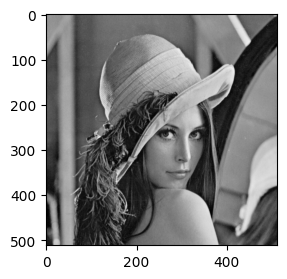

In [3]:
# 圖片大小 512x512x3
path = "./data"
imgfile = path + r"\lenna.png"
# lenna = mpimg.imread(imgfile)
# if len(X.shape) > 2:
#     lenna = np.mean(X, axis=2) # convert RGB to grayscale
lenna = io.imread(imgfile, as_gray = True)
print('【圖片大小】:', lenna.shape)

fig = plt.figure(figsize=(3, 3))
plt.imshow(lenna, cmap = 'gray')
plt.show()

<hr>

#### (2) 設定 patch 大小為 16 $\times$ 16，並取 $q = 16$，觀察將原圖細分成多個小圖後，再進行 **Rank q approximation** 後所呈現出的模樣，並與原圖進行比較，了解其視覺差異，同時計算對應的壓縮比例（Compression Ratio）。

**壓縮比例公式：**

由於每張 $16 \times 16$ 的 patch 都會分別進行奇異值分解（SVD），並僅保留前 $q = 16$ 個主成分，因此每個 patch 必須儲存：

- $q$ 個特徵值（或係數），對應投影後的座標（每個 patch 對應 $q$ 維向量）
- $q$ 個主成分（長度為 256 的向量）

總儲存成本為：
$$\text{Storage cost} = q \cdot p^2 + q \cdot \frac{m \cdot n}{p^2}$$

因此壓縮比例為：
$$\text{Compression Ratio} = \frac{m \cdot n}{q \cdot \left(p^2 + \frac{m \cdot n}{p^2} \right)}$$

以本例中 $m = 512$, $n = 512$, $p = 16$, $q = 16$ 為例：
$$
\text{Compression Ratio} 
= \frac{512 \cdot 512}{16 \cdot \left(256 + \frac{512 \cdot 512}{256} \right)}
= \frac{262144}{16 \cdot (256 + 1024)} 
= \frac{262144}{16 \cdot 1280} 
= \frac{262144}{20480} 
\approx 12.8
$$

【Patches 總數】: 1024
【每個 patch 的大小】: 256
【壓縮比例 Compression Ratio】: 12.8


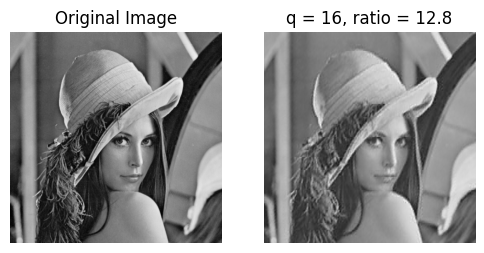

In [4]:
# 將圖片分 patches 16 x 16
patch_size = 16
patches = view_as_blocks(lenna, block_shape=(patch_size, patch_size))
M = patches.reshape(-1, patch_size * patch_size) # flatten the patches

print("【Patches 總數】:", M.shape[0])
print("【每個 patch 的大小】:", M.shape[1])

# 定義 q 值
q = 16

# 進行 SVD 分解
svd = TruncatedSVD(n_components=q, random_state = 0)    # 保留前 q 個奇異值
Z_q = svd.fit_transform(M.T)    # 輸入 shape (特徵數, 樣本數)
M_q = svd.inverse_transform(Z_q)    # 重建矩陣
# print(M_q.shape)

# 將 M 重組回到 lenna 的形狀
X_reconstructed = montage(M_q, patches.shape[0], patches.shape[1])
# ratio = (lenna.shape[0] * lenna.shape[1]) / (q * (lenna.shape[0] + lenna.shape[1]))
m, n = lenna.shape
patch_size = 16  # 或其他大小
num_patches = (m * n) / (patch_size ** 2)
compressed_storage = q * (patch_size ** 2) + q * num_patches
ratio = (m * n) / compressed_storage
print("【壓縮比例 Compression Ratio】:", ratio)

fig = plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plt.imshow(lenna, cmap='gray')
plt.title("Original Image")
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(X_reconstructed, cmap='gray')
plt.title(f"q = {q}, ratio = {ratio}")
plt.axis('off')
plt.show()

##### **<font color=lightseagreen>注意事項與討論：</font>**  

- 本實驗將 Lenna 圖切割成 $16 \times 16$ 大小的小圖，共產生 1024 張 patch，接著針對這些小圖進行 **Rank q approximation**，最後再將其重組回原始圖片的模樣。

- 左圖為原始圖片，右圖為重建後的近似圖片。從視覺效果來看，從視覺效果來看，右圖相較於左圖略顯模糊，顯示影像確實經過壓縮處理，且根據壓縮比例公式，壓縮比例為 12.8 倍，驗證了透過將圖片切割為小圖再進行壓縮的作法是可行的。

- 然而，僅觀察這兩張圖片仍無法得知 patch 大小對壓縮效果的實際影響。因此，接下來將進一步設計實驗，針對不同的 patch 大小進行比較分析。

<hr>

#### (3) 分別設定 $q$ 值為 8、16、32、64，計算各自對應的壓縮比例，並觀察 Lenna 圖在不同 $q$ 值下與原圖之間的差異。接著，將 patch 大小依序設定為 8 $\times$ 8、16 $\times$ 16、32 $\times$ 32、64 $\times$ 64，觀察在每一種 patch size 下，相同 $q$ 值所得到的近似圖片的差異，分析不同的 patch 大小與 $q$ 值的組合對於影像壓縮的影響。

##### 1) 定義 patch_plot 函數。

**使用說明：** \
將輸入圖片依照指定的 patch 大小進行切割，接著分別以 $q$ = 8、16、32、64 進行影像壓縮，最後將原圖與近似後的圖片繪製出來。

**Inputs**:
- `X`: 原始圖片資料，形狀為 $(m, n)$，其中 $m$ 為圖片的行數，$n$ 為圖片的列數（例如 Lenna 圖為 512 $\times$ 512）。
- `size`: 要拆的 Patch Shape。

**Output**: \
總共輸出 1 $\times$ 5 共五張圖片，其中第 1 張為原圖，第 2 張為 $q$ = 8 的近似圖片，第 3 張為 $q$ = 16 的近似圖片，依此類推至 $q$ = 64。

In [11]:
def patch_plot(X, size):
    patch_size = size
    patches = view_as_blocks(X, block_shape=(patch_size, patch_size))
    M = patches.reshape(-1, patch_size * patch_size) # flatten the patches

    # print("Patches 的總數:", M.shape[0])
    # print("每個 patch 的大小:", M.shape[1])

    # 定義 q 值
    All_q = [64, 32, 16, 8]
    # q = 16

    fig, ax = plt.subplots(1, 5, figsize=(15, 3))
    ax[0].imshow(X, cmap='gray')
    ax[0].set_title("Original Image")
    ax[0].axis('off')

    for i, q in enumerate(All_q):
        # 進行 SVD 分解
        svd = TruncatedSVD(n_components=q, random_state=0)    # 保留前 q 個奇異值
        Z_q = svd.fit_transform(M.T)    # 輸入 shape (特徵數, 樣本數)
        M_q = svd.inverse_transform(Z_q)    # 重建矩陣

        # 將 M 重組回到 X 的形狀
        Xq = montage(M_q, patches.shape[0], patches.shape[1])
        # ratio = (X.shape[0] * X.shape[1]) / (q * (X.shape[0] + X.shape[1]))
        m, n = X.shape
        num_patches = (m * n) / (patch_size ** 2)
        compressed_storage = q * (patch_size ** 2) + q * num_patches
        ratio = round((m * n) / compressed_storage, 2)

        ax[i+1].imshow(Xq, cmap='gray')
        ax[i+1].set_title(f"q = {q}, ratio = {ratio}")
        ax[i+1].axis('off')

    plt.suptitle(f"Patch Size = {patch_size}", fontsize=15)
    plt.show()

##### 2) 分別繪製出 patch 大小為 (8 $\times$ 8)、(16 $\times$ 16)、(32 $\times$ 32)、(64 $\times$ 64) 的近似圖片，比較在相同 $q$ 值下，圖與圖之間的差異。

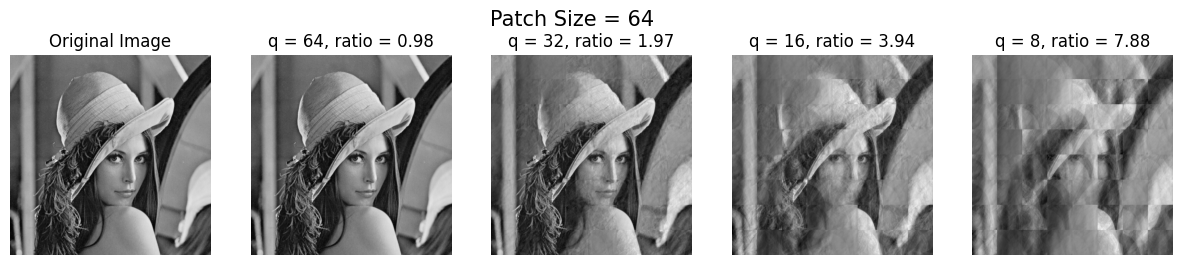

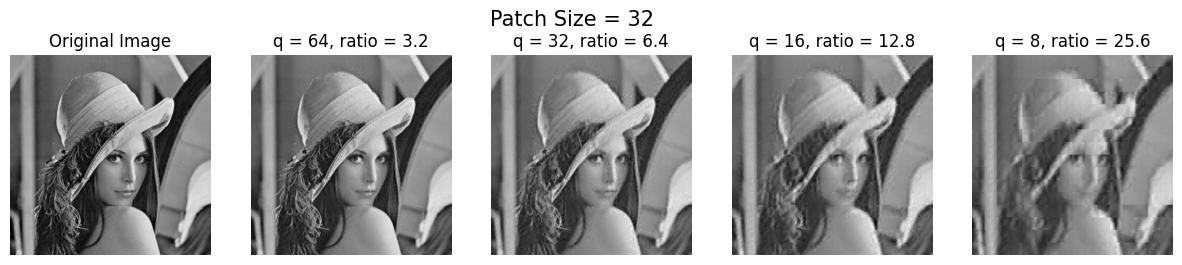

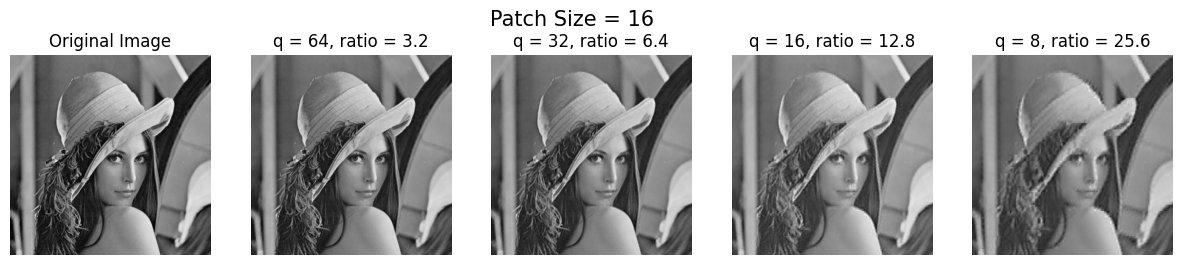

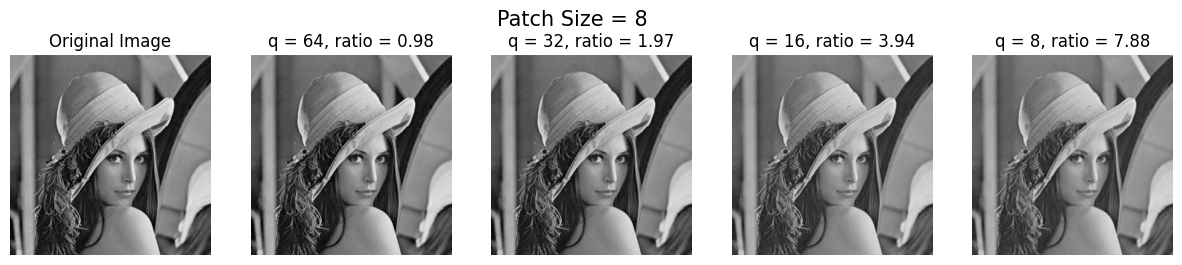

In [12]:
# 設定 patch shape
All_q = [64, 32, 16, 8]

# 繪製 lenna 圖
for q in All_q:
    patch_plot(lenna, q)

##### **<font color=lightseagreen>注意事項與討論：</font>**  

- 本實驗展示在不同 patch size 條件下，圖片經過壓縮所產生的視覺效果。每一行代表不同的 patch size，依序往下分為 patch size = 64、32、16、8；每一列則由左至右分別為原始圖片以及對應 $q$ = 64、32、16、8 的近似圖片。

- 從結果中可以清楚看出，當 patch size 為 64 $\times$ 64 時，隨著 q 值降低，圖片會變得越來越模糊，顯示壓縮比例越高，影像品質損失也越明顯。然而，當 patch size 越小（圖片切得越細），即便在相同的壓縮條件（相同 q 值）下，可發現圖片的清晰度仍能有效保留，尤其是當 patch size 為 8 $\times$ 8 時，即使 $q = 8$，近似圖片仍與原圖非常接近，幾乎看不出模糊。

- 綜合觀察可得，隨著 q 值下降，壓縮強度提高，影像清晰度會受到明顯影響。但若結合 patch 切割的方式，即使壓縮比例很高，仍可有效保留圖片細節與清晰度，達到更理想的壓縮效果。因此，**先切割再壓縮**是一種提升壓縮品質的可行方法。

<hr>

#### (4) 更換圖片（如 Afghan Girl 圖片），重複上述實驗步驟，以驗證先前的結果是否具有普遍性，並非僅適用於 Lenna 圖。

##### 1) 匯入 Afghan Girl 圖片，觀察圖片的模樣。

【圖片大小】: (612, 612)


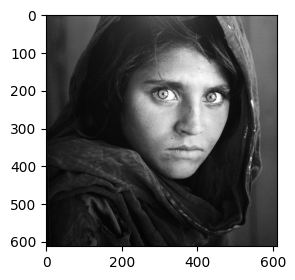

In [14]:
# 圖片大小 612x612x3
path = "./data"
imgfile = path + r"\afghan_girl.jpg"
afghan = io.imread(imgfile, as_gray = True)
print('【圖片大小】:', afghan.shape)

fig = plt.figure(figsize=(3, 3))
plt.imshow(afghan, cmap = 'gray')
plt.show()

##### 2) 分別繪製出 patch 大小為 (9 $\times$ 9)、(18 $\times$ 18)、(36 $\times$ 36)、(68 $\times$ 68) 的近似圖片，比較在相同 $q$ 值下，圖與圖之間的差異。

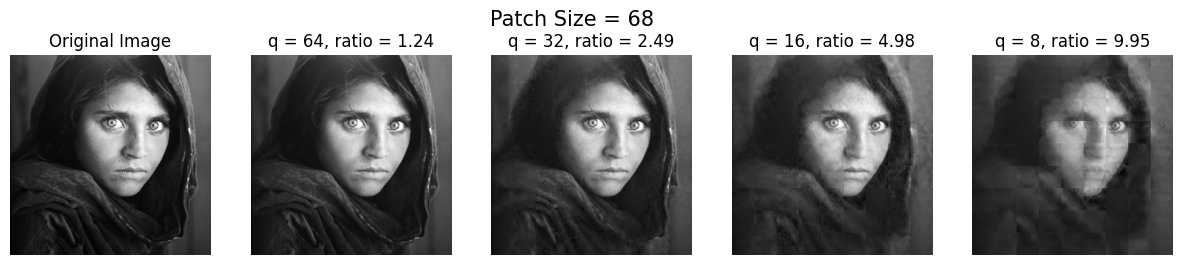

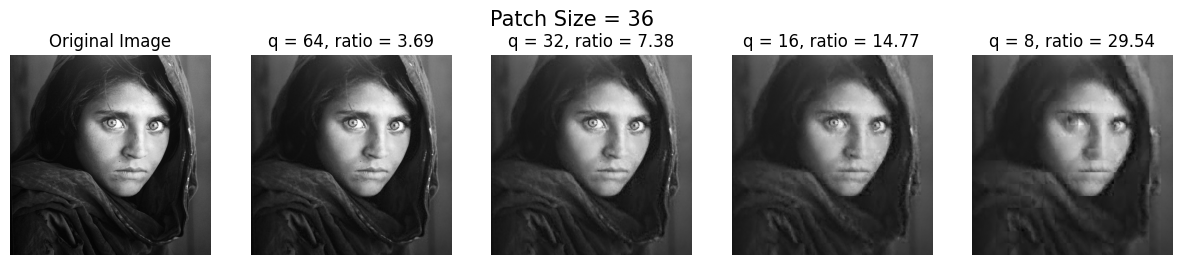

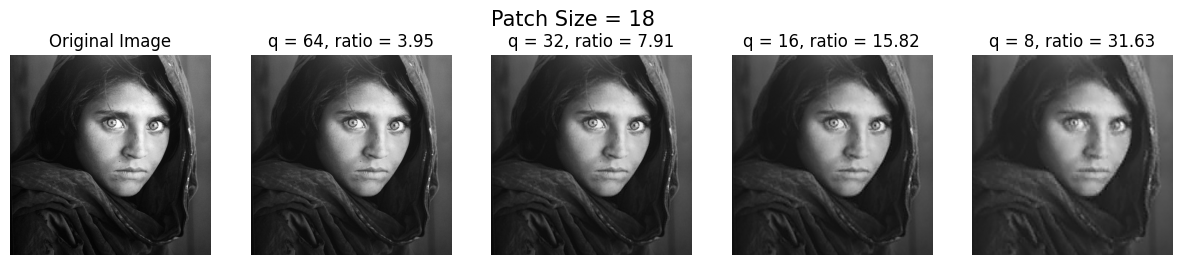

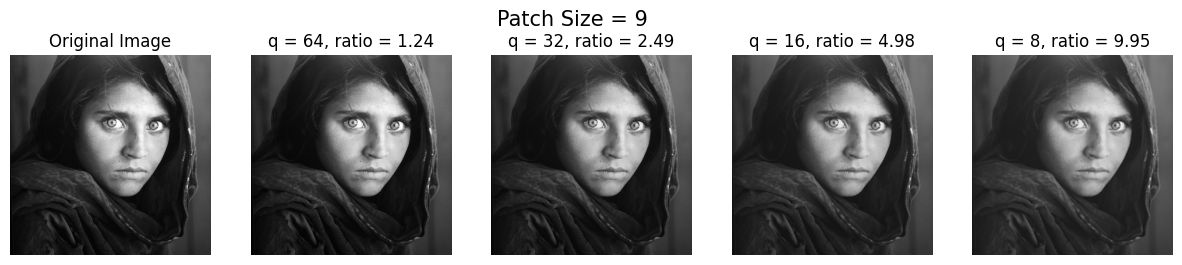

In [15]:
# 設定 patch shape
All_q = [68, 36, 18, 9]

# 繪製 afghan girl 圖
for q in All_q:
    patch_plot(afghan, q)

##### **<font color=lightseagreen>注意事項與討論：</font>**  

- 此實驗展示了在不同的 patch size 設定下，圖片在進行 SVD 壓縮時的視覺變化。圖片每一行對應不同的 patch size（依序為 68、36、18、9），而每一列則對應不同的 $q$ 值（從左到右依序為原圖、$q$ = 64、32、16、8 所得之近似圖）。

- 與前一小題的結果一致，當 patch size 越小，即使 $q$ 值較低，圖片仍能保持較高的清晰度。這驗證了透過細分圖片後再壓縮的方式，能在高壓縮比例的同時維持影像品質，有效減少與原圖的視覺差異。

- 此方法在影像壓縮上具備顯著優勢，能夠在大幅減少儲存空間的同時，維持良好的視覺效果，對於需大量儲存圖片資料的應用情境特別有幫助。

<hr>
<hr>

### **<font color=cornflowerblue>第 3 題：</font>**  

本題以 SVD 製作影像的**加密與解密**。

首先，實驗利用 Yale Faces 的 2410 張圖製作**加密**使用的 $U_q$ 矩陣，並透過 $U_q$ 矩陣畫出 **Eigenfaces**，觀察 2410 位 Yale 學生的共同 **Features**。

此外，另外尋找 5 張其他照片，分別為風景、蘋果、Doraemon、Lenna 與 Yale 第一位學生的人臉圖，其大小 Resize 成與 Yale Faces 的大小 $192 \times 168$（高度 $\times$ 寬度）相同。接著，利用先前 Yale Faces 的 $U_q$ 矩陣對這 5 張圖片**進行加密，後再解密**，選擇不同大小的 $q$ 值進行比較，觀察這些解密後的影像效果，判斷是否人臉的表現比較好，以及其他非人臉影像，如風景影像，是否能透過由人臉建構的特徵 $U_q$ 進行加密，即解密後能否看到原圖模樣，以及清晰度如何。

**理論說明：**
- 在 SVD 中，$U$ 與 $V^T$ 雖然都是特徵向量所構成的正交矩陣，但兩者所代表的意義有所不同：

    - $U$（左奇異向量）對應原始資料矩陣 $X$ 的列空間（row space），在影像資料中代表每一筆樣本（如每張圖片）如何沿著主成分方向投影，因此 $U$ 中的向量可視為樣本在主成分空間中的表示，也即為 Eigenfaces 的基底組成。

    - $V^T$（右奇異向量）對應於 $X$ 的欄空間（column space），在影像中代表每個像素在主成分方向上的投影方式，因此反映了原始變數（像素）在資料中的主要變異方向，常用來理解特徵在空間中的分布結構。

- $U$ 描述的是每筆資料在主成分空間中的投影表現（樣本的特徵向量），而 $V^T$ 則描述的是原始特徵（像素）如何對這些主成分作出貢獻（變數的特徵向量）。

**圖片來源**：
1. Yale Faces: https://github.com/heliumind/eigenfaces/blob/master/data/allFaces.mat

1. 風景圖: https://images.pexels.com/photos/16634037/pexels-photo-16634037.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=1

1. 蘋果圖: https://media.istockphoto.com/id/184276818/zh/%E7%85%A7%E7%89%87/red-apple.jpg?s=612x612&w=0&k=20&c=jqr-Dw4LvXapRufzvb4ZcCfNeR_TlDlBk52-_PwlOR0=

1. Doraemon 圖: https://hmjh20329.weebly.com/uploads/2/7/0/5/27056819/3966447_orig.jpg

1. Lenna 圖: 在老師講義上

1. Yale 第一位學生的圖: 取出 Yale Faces 的第一張圖

#### (1) 匯入 Yale Faces 圖片，觀察圖片的模樣。

【資料的 keys】：
 dict_keys(['__header__', '__version__', '__globals__', 'faces', 'n', 'm', 'sub', 'nfaces', 'person'])
【影像矩陣形狀】： (32256, 2410)
【總人數】： (38,)
【影像的寬度、高度、人數】： 168 192 38
【每個人的影像數量】：
 [64 62 64 64 62 64 64 64 64 64 60 59 60 63 62 63 63 64 64 64 64 64 64 64
 64 64 64 64 64 64 64 64 64 64 64 64 64 64]


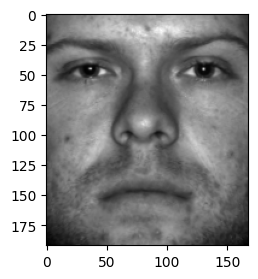

In [30]:
# 匯入影像資料
D = scipy.io.loadmat(r'C:\Users\Sheng\Documents\NTPU_Bachelor\Year_4\Y4_Sem_2\ShallowML\ClassData\allFaces.mat')
print("【資料的 keys】：\n", D.keys())
X = D['faces'] # 32256 x 2410 each column represents an image
y = np.ndarray.flatten(D['nfaces'])
m = D['m'].item() # 168
n = D['n'].item() # 192
n_persons = D['person'].item() # 38

print("【影像矩陣形狀】：", X.shape)
print("【總人數】：", y.shape)
print("【影像的寬度、高度、人數】：", m, n, n_persons)
print("【每個人的影像數量】：\n", y) # 1 to 38

# 取出第 1 個人的影像
face = X[:, 0].reshape(m, n).T  # matlab 的影像是 column-major order, 所以要轉置
fig = plt.figure(figsize=(3, 3))
plt.imshow(face, cmap = 'gray')
plt.show()

<hr>

#### (2) 對 Yale 學生人臉圖進行 SVD 分解，並製作**加密**使用的 $U_q$ 矩陣，畫出前 10 張 **Eigenfaces**，觀察 2410 位 Yale 學生前 10 個共同的 **Features**。

In [31]:
# sklearn 執行速度 = 2 mins
sksvd = TruncatedSVD(n_components=X.shape[1], random_state=42)
Z = sksvd.fit_transform(X.T)
sk_U = sksvd.components_.T

In [32]:
# numpy 執行速度 = 1 min
U, E, VT = svd(X, full_matrices = False)

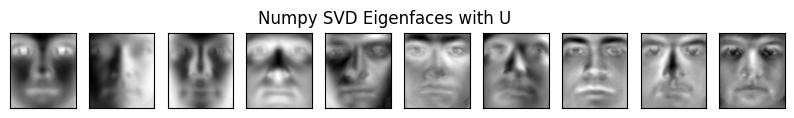

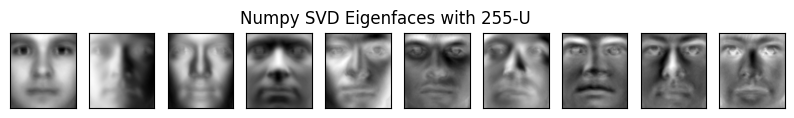

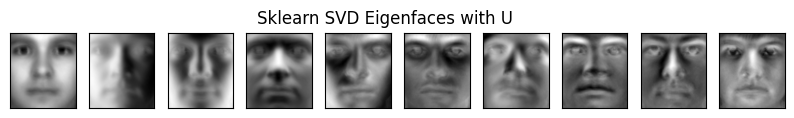

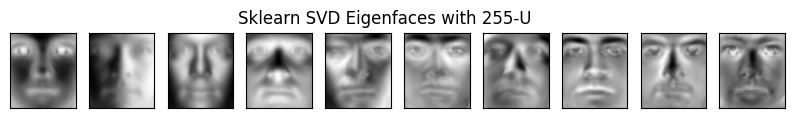

In [33]:
# numpy SVD 的 eigenfaces
show_montage(U, m, n, 1, 10, title='Numpy SVD Eigenfaces with U')
# 255 - U 表示暗亮互換
show_montage(255 - U, m, n, 1, 10, title='Numpy SVD Eigenfaces with 255-U')

# sklearn SVD 的 eigenfaces
show_montage(sk_U, m, n, 1, 10, title='Sklearn SVD Eigenfaces with U')
# 255 - U 表示暗亮互換
show_montage(255 - sk_U, m, n, 1, 10, title='Sklearn SVD Eigenfaces with 255-U')

##### **<font color=lightseagreen>注意事項與討論：</font>**  

- 本實驗展示如何分別使用 NumPy 與 scikit-learn 進行 SVD 分解，並利用 $U_q$ 繪製前 10 位 Yale 學生的 **Eigenfaces**，藉此觀察這些學生的共通特徵。第一、二行使用的是 NumPy 的 SVD，第三、四行則採用 scikit-learn 的 SVD。儘管這兩者產生的 $U_q$（或其反相 $255 - U_q$）在圖像的色彩表現上略有差異，樣貌本身卻一致，顯示兩套件計算的特徵向量在數值上可能有符號或縮放差異，但其代表的資訊一致，故仍具有相同意義。

- 第一張 **Eigenface** 最清楚地呈現出 2410 位學生的共通面貌特徵，代表了資料中最主要的變異來源。隨著特徵向量的編號增加，圖像變得越來越模糊，說明這些向量捕捉的是越來越細微、次要的變化。因此，前幾個主成分保留了最關鍵的臉部特徵，而後面的則主要記錄微小差異。

<hr>

#### (3) 另外尋找 5 張其他圖片，分別為風景、蘋果、Doraemon、Lenna 與 Yale 第一位學生的人臉圖，使用先前 Yale Faces 的 $U_q$ 矩陣對這 5 張圖片**進行加密，後再解密**，觀察這些解密後的影像效果。

##### 1) 匯入 5 張圖片，Resize 成 $192 \times 168$（高度 $\times$ 寬度），並展示出圖片。

【風景圖大小】: (750, 500)
【蘋果圖大小】: (612, 612)
【Doraemon 圖大小】: (247, 204)
【Lenna 圖大小】: (512, 512)
【Yale 第一位學生的圖大小】: (192, 168)


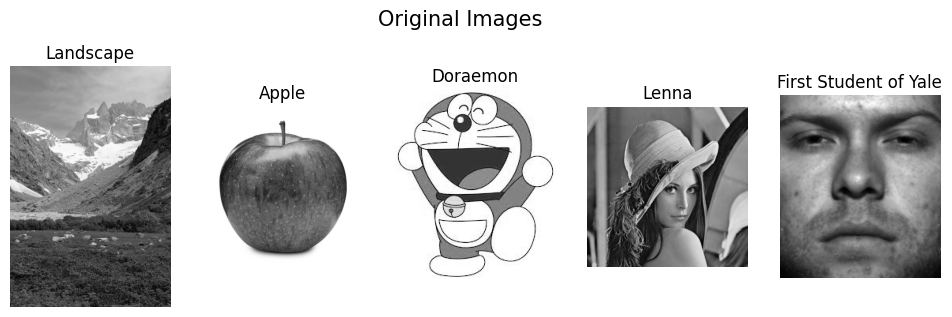

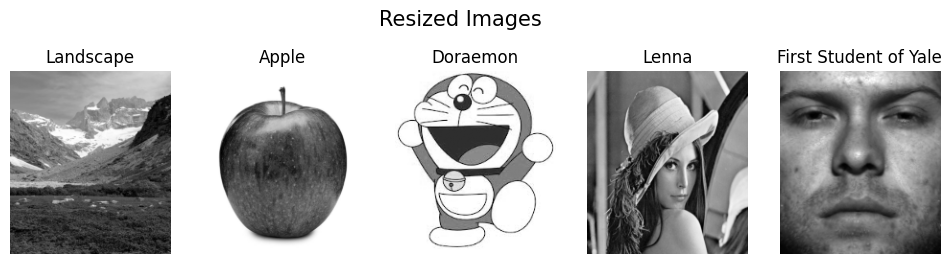

In [ ]:
# 風景圖
imgfile = r"C:\Users\Sheng\Documents\NTPU_Bachelor\Year_4\Y4_Sem_2\ShallowML\ClassData\landscape.jpeg"
landscape = io.imread(imgfile, as_gray = True)
# 蘋果圖
imgfile = r"C:\Users\Sheng\Documents\NTPU_Bachelor\Year_4\Y4_Sem_2\ShallowML\ClassData\apple.jpg"
apple = io.imread(imgfile, as_gray = True)
# Doraemon 圖
imgfile = r"C:\Users\Sheng\Documents\NTPU_Bachelor\Year_4\Y4_Sem_2\ShallowML\ClassData\doraemon.jpg"
doraemon = io.imread(imgfile, as_gray = True)
# Lenna 圖
imgfile = r"C:\Users\Sheng\Documents\NTPU_Bachelor\Year_4\Y4_Sem_2\ShallowML\ClassData\lenna.png"
lenna = io.imread(imgfile, as_gray = True)
# Yale 第一位學生的圖
yale_first_person = X[:, 1].reshape(m, n).T

print('【風景圖大小】:', landscape.shape)
print('【蘋果圖大小】:', apple.shape)
print('【Doraemon 圖大小】:', doraemon.shape)
print('【Lenna 圖大小】:', lenna.shape)
print('【Yale 第一位學生的圖大小】:', yale_first_person.shape)

########################################################

# 將圖片縮放到 192x168
def resize_image(image, size):
    """
    將圖片調整到指定大小
    Inputs:
    image: 原始圖片
    size: 調整後的大小 (height, width)
    Output:
    resized_image: 調整後的圖片
    """
    resized_image = resize(image, size, anti_aliasing=True)
    return resized_image

re_landscape = resize_image(landscape, (192, 168))
re_apple = resize_image(apple, (192, 168))
re_doraemon = resize_image(doraemon, (192, 168))
re_lenna = resize_image(lenna, (192, 168))

# print('【調整後的圖片大小】: ', resized_landscape.shape)

# 原始圖片
fig, ax = plt.subplots(1, 5, figsize=(12, 5))
photo = [landscape, apple, doraemon, lenna, yale_first_person]
title = ['Landscape', 'Apple', 'Doraemon', 'Lenna', 'First Student of Yale']
for i, img in enumerate(photo):
    ax[i].imshow(img, cmap='gray')
    ax[i].set_title('{}'.format(title[i]))
    ax[i].axis('off')
plt.suptitle('Original Images', y=0.85, fontsize=15)
plt.show()

# 近似圖片
fig, ax = plt.subplots(1, 5, figsize=(12, 5))
re_photo = [re_landscape, re_apple, re_doraemon, re_lenna, yale_first_person]
for i, img in enumerate(re_photo):
    ax[i].imshow(img, cmap='gray')
    ax[i].set_title('{}'.format(title[i]))
    ax[i].axis('off')
plt.suptitle('Resized Images', y=0.8, fontsize=15)
plt.show()

##### 2) 利用 $U_q$ 對 5 張圖片進行加密，後再解密，觀察與比較不同的 q 所加解密的圖與原圖的差異。

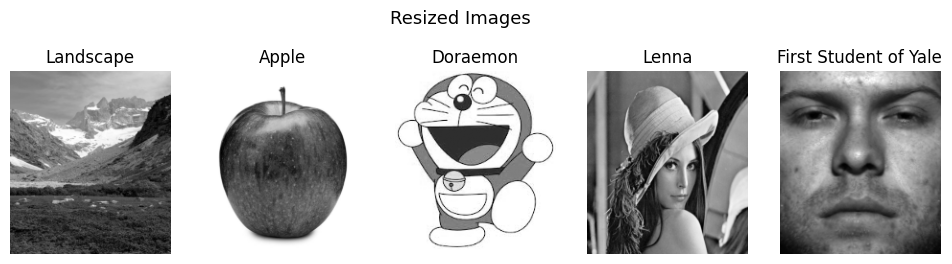

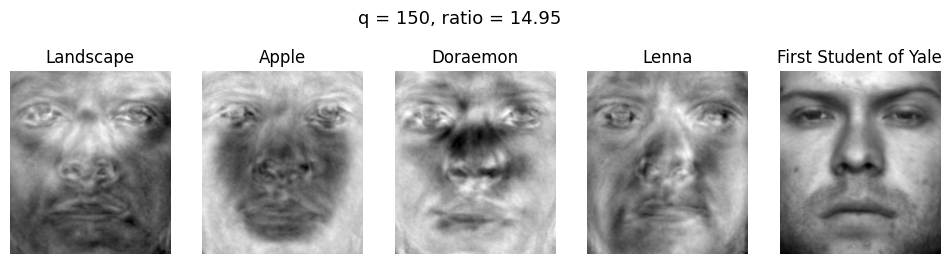

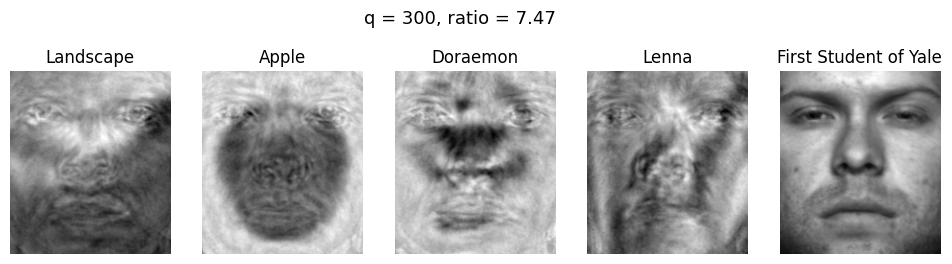

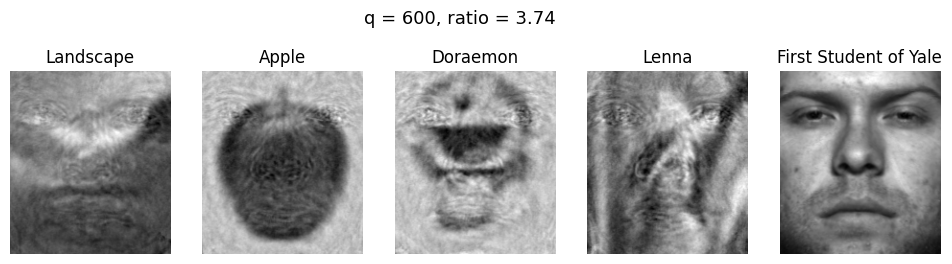

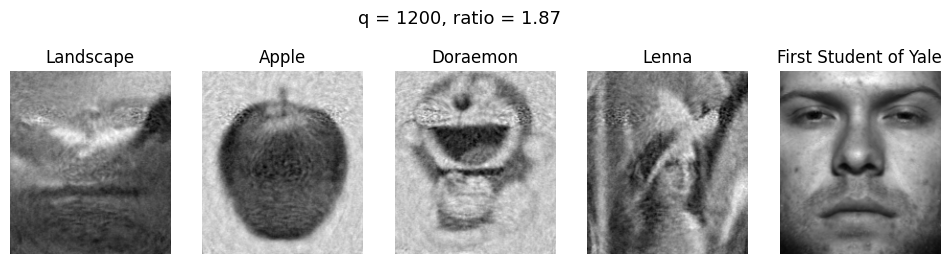

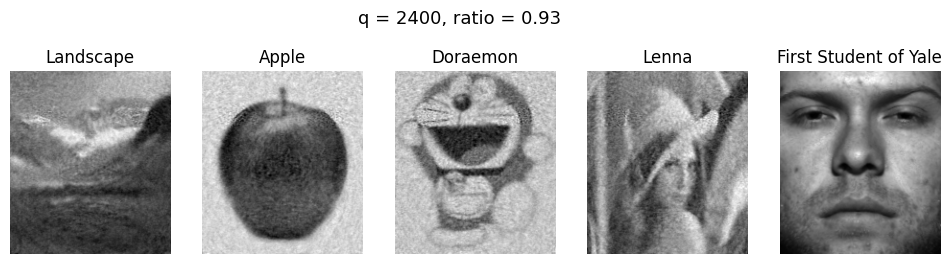

In [ ]:
# 進行加解密
def crypt(re_X, q):
    """
    將圖片加密
    Inputs:
    re_X: 原始圖片
    q: 主成分數量
    Output:
    Xq_orig: 加解密後的原本圖片
    """
    re_XT = re_X.T.reshape(m*n, -1)
    Uq = U[:, :q]        # 取 Yale 人臉的 U 的前 q 列
    Xq_crypt = Uq @ (Uq.T @ re_XT) # 32256 x 10

    # 轉制回原來的形狀
    Xq_orig = Xq_crypt.reshape(168, 192).T
    return Xq_orig

# 原始圖片
fig, ax = plt.subplots(1, 5, figsize=(12, 5))
re_photo = [re_landscape, re_apple, re_doraemon, re_lenna, yale_first_person]
title = ['Landscape', 'Apple', 'Doraemon', 'Lenna', 'First Student of Yale']
for i, img in enumerate(re_photo):
    ax[i].imshow(img, cmap='gray')
    ax[i].set_title('{}'.format(title[i]))
    ax[i].axis('off')
plt.suptitle('Resized Images', y=0.8, fontsize=13)
plt.show()

All_q = [150, 300, 600, 1200, 2400]

for q in All_q:
    # 進行加解密
    crypt_landscape = crypt(re_landscape, q)
    crypt_apple = crypt(re_apple, q)
    crypt_doraemon = crypt(re_doraemon, q)
    crypt_lenna = crypt(re_lenna, q)
    crypt_yale_first_person = crypt(yale_first_person, q)

    # 近似圖片
    fig, ax = plt.subplots(1, 5, figsize=(12, 5))
    crypt_photo = [crypt_landscape, crypt_apple, crypt_doraemon, crypt_lenna, crypt_yale_first_person]
    ratio = X.shape[0] * X.shape[1] / (q * X.shape[0] + q * X.shape[1])
    for i, img in enumerate(crypt_photo):
        ax[i].imshow(img, cmap='gray')
        ax[i].set_title('{}'.format(title[i]))
        ax[i].axis('off')
    plt.suptitle('q = {}, ratio = {:.2f}'.format(q, ratio), y=0.8, fontsize=13)
    plt.show()

##### **<font color=lightseagreen>注意事項與討論：</font>**  

- 當 $q$ 值較小（例如 $q = 150$）時，除了 Yale 第一位學生的圖像已經相對清晰外，其餘圖片幾乎無法辨識，與原圖的關聯性也不明顯。隨著 $q$ 值增加，至 $q = 1200$ 時，圖像的輪廓才逐漸明朗；當 $q$ 達到 2400 時，圖像才變得相對清晰。然而，即使繼續增加 $q$ 值，圖像的清晰度也不再有顯著提升。

- 從上述結果可以看出，使用 Yale 人臉圖像所建立的特徵向量 $U_q$ 對其他圖像進行壓縮與重建的效果有限。除了對同樣屬於 Yale 資料集中第一位學生的圖像能有效還原外，其餘圖像直到 $q = 1200$ 才能勉強辨識，而此時所需的 $q$ 值已相當高，表示壓縮效率不佳。因此，使用基於人臉圖像所建構的特徵空間來處理非人臉影像，並非理想的做法。

<hr>